Possible datasets
 - https://data.world/crowdflower/apple-twitter-sentiment
 - https://paperswithcode.com/dataset/stocknet-1
 - https://www.kaggle.com/datasets/equinxx/stock-tweets-for-sentiment-analysis-and-prediction
 - https://www.kaggle.com/datasets/thedevastator/tweet-sentiment-s-impact-on-stock-returns
 - https://ieee-dataport.org/open-access/stock-market-tweets-data
 - https://www.kaggle.com/datasets/yash612/stockmarket-sentiment-dataset
 - https://www.kaggle.com/datasets/kazanova/sentiment140

In [20]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

from torch.utils.data import Dataset, DataLoader
import time
from multiprocessing import Pool
from tqdm import tqdm
import seaborn as sns
import nltk
import fasttext
# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Howard\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Loading:

In [3]:
RANDOM_STATE = 2023
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
SEQUENCE_LENGTH = 300
CURRENT_DIRECTORY = os.getcwd()

dataset_filename = {
    '0': ("training.1600000.processed.noemoticon.csv", ["target", "ids", "date", "flag", "user", "text"])
}
dataset_path = os.path.join("", "data", dataset_filename["0"][0])
df = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["0"][1])

## Preprocessing:

In [4]:
%%time
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
df.target = df.target.apply(lambda x: decode_map[int(x)])

stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

def preprocess(text, stem=False):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = [word for word in text.split() if word not in stop_words]
    if stem:
        tokens = [stemmer.stem(token) for token in tokens]
    return " ".join(tokens)

df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 37.2 s


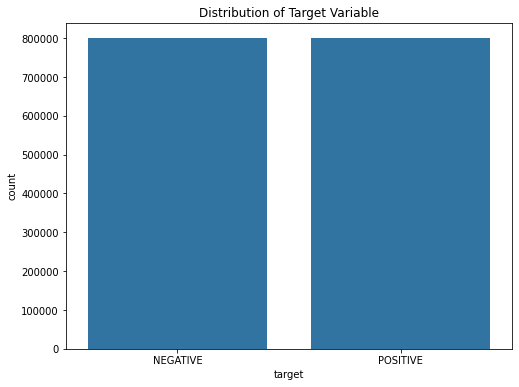

In [5]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='target')
plt.title('Distribution of Target Variable')
plt.show()

In [6]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=RANDOM_STATE)

### FastText Training: https://www.analyticsvidhya.com/blog/2023/01/introduction-to-fasttext-embeddings-and-its-implication/

In [7]:
%%time
if os.path.isfile(os.path.join(CURRENT_DIRECTORY, "fasttext_model.bin")):
    fasttest_model = fasttext.load_model("fasttext_model.bin")
else:
    fasttext_train = 'fasttext_train.txt'
    df_train['text'].to_csv(fasttext_train, index=False, header=False)
    fasttest_model = fasttext.train_unsupervised(fasttext_train, model='skipgram')
    fasttest_model.save_model("fasttext_model.bin")

Wall time: 740 ms


### Tokenization:

In [8]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)
vocab_size = len(tokenizer.word_index) + 1

x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)


Wall time: 27.4 s


In [9]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Wall time: 15.3 s


### Label Encoder:

In [10]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist()).reshape(-1,1)
y_test = encoder.transform(df_test.target.tolist()).reshape(-1,1)


### Embedding Layer:

In [11]:
%%time
EMBEDDING_DIM = fasttest_model.get_dimension()
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_matrix[i] = fasttest_model.get_word_vector(word)

Wall time: 3.42 s


## Preparation for PyTorch Model:

In [12]:
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = torch.tensor(self.texts[idx], dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return text, label

BATCH_SIZE = 128
train_dataset = TextDataset(x_train, y_train)
test_dataset = TextDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [13]:
class SentimentClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=100):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float))
        self.dropout = nn.Dropout(0.5)
        self.lstm = nn.LSTM(embedding_matrix.shape[1], hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1])
        x = self.fc(x)
        x = self.sigmoid(x)
        return x.squeeze()


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier(embedding_matrix).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
SAVE_PATH = "model/"

# Check if multiple GPUs are available and wrap the model with DataParallel if they are
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate if needed

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model_name = f"rnn_bs{BATCH_SIZE}_epoch{epoch+1}.pt"
    model_path = os.path.join(SAVE_PATH, model_name)
    
    # Check if the model for this epoch already exists
    if os.path.exists(model_path):
        print(f"Loading model from {model_path}")
        model.load_state_dict(torch.load(model_path))
        
        # Validation loop for accuracy
        model.eval()
        correct_preds = 0
        total_preds = 0
        if epoch == num_epochs-1:
            with torch.no_grad():
                for x, y in test_loader:
                    x, y = x.to(device), y.to(device)
                    outputs = model(x)
                    preds = torch.round(outputs)
                    correct_preds += (preds == y.squeeze()).sum().item()
                    total_preds += y.size(0)
            accuracy = correct_preds / total_preds
            print(f"Loaded Model Epoch {epoch+1}, Accuracy: {accuracy:.4f}")
        continue

    model.train()
    total_loss = 0
    # Wrap train_loader with tqdm for progress bar
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y.squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation loop for accuracy after training
    model.eval()
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = torch.round(outputs)
            correct_preds += (preds == y.squeeze()).sum().item()
            total_preds += y.size(0)
    accuracy = correct_preds / total_preds

    torch.save(model.state_dict(), model_path)
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}, Accuracy: {accuracy:.4f}")


Loading model from model/rnn_bs128_epoch1.pt
Loading model from model/rnn_bs128_epoch2.pt
Loading model from model/rnn_bs128_epoch3.pt
Loading model from model/rnn_bs128_epoch4.pt
Loading model from model/rnn_bs128_epoch5.pt


Epoch 6/10: 100%|██████████| 10000/10000 [03:15<00:00, 51.24it/s]


Epoch 6, Loss: 0.4324759402304888, Accuracy: 0.7951


Epoch 7/10: 100%|██████████| 10000/10000 [03:22<00:00, 49.38it/s]


## Evaluate

Accuracy: 0.7933
F1-Score: 0.7906
ROC-AUC: 0.8782


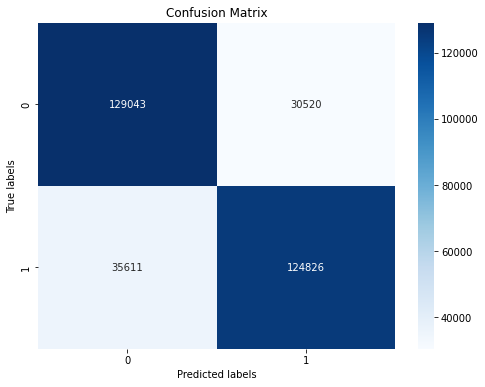

              precision    recall  f1-score   support

    NEGATIVE       0.78      0.81      0.80    159563
    POSITIVE       0.80      0.78      0.79    160437

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



In [25]:
# Predict on test data
model.eval()
y_pred_probs = []
with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)
        outputs = model(x)
        y_pred_probs.extend(outputs.cpu().numpy())

# Convert probabilities to binary predictions
threshold = 0.5
y_pred = [1 if prob > threshold else 0 for prob in y_pred_probs]

# Convert y_test to a flat list
y_true = y_test.squeeze().tolist()

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# F1-Score
f1 = f1_score(y_true, y_pred)
print(f"F1-Score: {f1:.4f}")

# ROC-AUC
roc_auc = roc_auc_score(y_true, y_pred_probs)
print(f"ROC-AUC: {roc_auc:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=['NEGATIVE', 'POSITIVE'])
print(report)
